In [ ]:
! pip install -U sentence-transformers
from google.colab import drive
drive.mount('gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
import gensim.downloader as gs
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer('whaleloops/phrase-bert')
embed_length = len(model.encode("yeet"))

In [ ]:
def clean(s):
  s = str(s)
  s = s.lower()
  for i in "(),\t\n<>":
    s = s.replace(i, "")
  for i in "-":
    s = s.replace(i, " ")
  return s

In [ ]:
NUM_LANGUAGE = 3156 # This is the number of languages used in the CLICS database
df = pd.read_csv("gdrive/MyDrive/FUSRP/filtered_dat_sem_shift.csv") 
df["meaning1"] = df["meaning1"].apply(clean)
df["meaning2"] = df["meaning2"].apply(clean)
df.head()

,Unnamed: 0,meaning1,meaning2,realizations
0,0,gunpowder,quick,1
1,1,gunpowder,small quantity of something,1
2,2,august,harvest,3
3,3,coleus plectranthus rotundifolius,potato,1
4,4,easter,ladybird,1


In [ ]:
senses = list(set(list(df["meaning1"])+list(df["meaning2"]))) # List of all senses appearing in datsemshift
sense_indices = {senses[i]:i for i in range(len(senses))} # Dictionary that gives a sense's index in senses
vec_dic = {s:model.encode(s) for s in senses} # Dictionary that gives a sense's phrase-BERT embedding

In [ ]:
np.array([vec_dic[s] for s in senses]).mean(axis=0)[:10] # Just to see if we should be worried about not normalizing everything, all these values should be about equal

array([-0.22456324,  0.16192041, -0.30675998, -0.248432  ,  0.11964986,
        0.84313947,  0.8481171 ,  0.3465099 , -0.65135306,  0.09324015],
      dtype=float32)

In [ ]:
mean1_dic = {i:[vec_dic[df.iloc[j]["meaning1"]][i] for j in range(len(df))] for i in range(embed_length)} # These are all temporary dictionaries we use to create dataframes
mean2_dic = {embed_length+i:[vec_dic[df.iloc[j]["meaning2"]][i] for j in range(len(df))] for i in range(embed_length)}
sense_embed_dic = {i:[vec_dic[s][i] for s in senses] for i in range(embed_length)}
dic = dict(mean1_dic)
dic.update(mean2_dic)
df_embeds = pd.DataFrame.from_dict(dic) # This is a dataframe of both embeddings concatenated for all the semantic shift pairs
df_sense_embeds = pd.DataFrame.from_dict(sense_embed_dic) # This is a dataframe of the embeddings of all of the senses. We convert this to a dataframe as we can run PCA on a dataframe

In [ ]:
from sklearn.decomposition import PCA
num_comps = 20 # Number of components we find in PCA
pca = PCA(n_components=num_comps)
principalComponents = pca.fit_transform(df_embeds ) # Embeddings for the datsemshift pairs. fit_transform tells PCA to fit the embeddings to this data
#print(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component ' + str(i) for i in range(1, num_comps+1)]) # Converts PCA embeddings to dataframe

pca_sense = PCA(n_components=num_comps) # Here we also find embeddings for all of the individual senses. We do this to see how similar our components are in datsemshift to the components of the individual senses. This helps measure whether the embeddings for pairs just capture patterns in the individual senses or whether it finds relationships between them
principalComponents_sense = pca_sense.fit_transform(df_sense_embeds)
#print(pca_meanings.explained_variance_ratio_)
mean1_components = np.array([principalComponents_sense[sense_indices[df.iloc[i]["meaning1"]]] for i in range(len(df))])
mean2_components = np.array([principalComponents_sense[sense_indices[df.iloc[i]["meaning2"]]] for i in range(len(df))])
mean1PrincipalDf = pd.DataFrame(data = mean1_components, columns = ['principal component ' + str(i) for i in range(1, num_comps+1)])
mean2PrincipalDf = pd.DataFrame(data = mean2_components
            , columns = ['principal component ' + str(i) for i in range(1, num_comps+1)])


In [ ]:
pca_compnum_to_sorted = [sorted([(principalDf.iloc[i]['principal component ' + str(comp)], df.iloc[i]["meaning1"], df.iloc[i]["meaning2"]) for i in range(len(df))]) for comp in range(1, num_comps+1)] # Sorted arrays of the senses/sense pairs that are lowest/highest for each embedding dimension
pca_compnum_to_sorted_mean1 = [sorted([(mean1PrincipalDf.iloc[i]['principal component ' + str(comp)], df.iloc[i]["meaning1"], df.iloc[i]["meaning2"]) for i in range(len(df))]) for comp in range(1, num_comps+1)]
pca_compnum_to_sorted_mean2 = [sorted([(mean2PrincipalDf.iloc[i]['principal component ' + str(comp)], df.iloc[i]["meaning1"], df.iloc[i]["meaning2"]) for i in range(len(df))]) for comp in range(1, num_comps+1)]

In [ ]:
for i in range(len(pca_compnum_to_sorted)): # Prints out the sense/sense pairs that are lowest for each embedding dimension. In the case for senses, it looks at those in meaning1 and those in meaning2 separately
  print("Pairs of data component number", str(i+1), end = " highest: ")
  print([(tup[1], tup[2]) for tup in pca_compnum_to_sorted[i]][:10])
  print("Pairs of data component number", str(i+1), end = " lowest: ")
  print([(tup[1], tup[2]) for tup in pca_compnum_to_sorted[i]][-10:])
  print("")
  print("Meaning 1 component number", str(i+1), end = " highest: ")
  print([tup[1] for tup in pca_compnum_to_sorted_mean1[i]][:10])
  print("Meaning 1 component number", str(i+1), end = " lowest: ")
  print([tup[1] for tup in pca_compnum_to_sorted_mean1[i]][-10:])
  print("")
  print("Meaning 2 component number", str(i+1), end = " highest: ")
  print([tup[2] for tup in pca_compnum_to_sorted_mean2[i]][:10])
  print("Meaning 2 component number", str(i+1), end = " lowest: ")
  print([tup[2] for tup in pca_compnum_to_sorted_mean2[i]][-10:])
  print("")
  print("")
  print("")

Pairs of data component number 1 highest: [('frog', 'toad'), ('hedgehog еrinaceus', 'chestnut'), ('bearded man', 'bearded vulture'), ('goat', 'sabrefish'), ('camel', 'ostrich'), ('wasp', 'hornet'), ('cuckoo', 'eurasian hoopoe'), ('mercury', 'mercury'), ('camel', 'humpbacked'), ('goat', 'hare lepus')]
Pairs of data component number 1 lowest: [('to press down', 'to restrain control one’s feelings'), ('to separate', 'to turn off'), ('to go out', 'to follow logically'), ('to put together', 'to reconcile'), ('to grasp seize', 'to understand'), ('to rein in', 'to restrain control one’s feelings'), ('to unfold unwind', 'to develop'), ('to get obtain', 'to contain'), ('to sway', 'to avoid'), ('to turn round', 'to appear emerge')]

Meaning 1 component number 1 highest: ['crocodile', 'crocodile', 'zebra', 'toad', 'frog', 'frog', 'frog', 'goat', 'goat', 'goat']
Meaning 1 component number 1 lowest: ['to get obtain', 'to get obtain', 'to get obtain', 'to get obtain', 'to get obtain', 'to get obtain

In [ ]:
arr = []
for j in range(num_comps):
  arr = arr + [[principalDf.iloc[i]['principal component '+str(j+1)] for i in range(len(df))], [mean1PrincipalDf.iloc[i]['principal component '+str(j+1)] for i in range(len(df))], [mean2PrincipalDf.iloc[i]['principal component '+str(j+1)] for i in range(len(df))]]
arr = np.array(arr) # Temporary array to be used to find correlations
#print(arr)

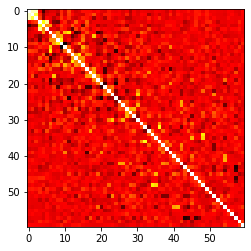

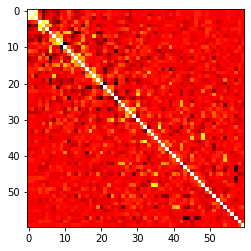

In [ ]:
# This creates a correlation heat plot for the variables in the order of: PCA of pair component 1, PCA of meaning1 component 1, PCA of meaning2 component 1, PCA of pair component 2, PCA of meaning1 component 2, PCA of meaning2 component 2, ...
# The idea here is that if for a certain principal component i, the components of meaning 1 and meaning2, and possibly of the pair are correlated, then the embedding for the pair is only looking at qualities of individual senses and not relationships between the qualities of the senses
# For example, the first 3 x 3 subgrid being very yellow follows from the first principle component corresponding to what parts of speech the two meanings are from, since they tend to be the same

rho_s, pval_s = stats.spearmanr(arr, axis=1) 
rho_p = np.array([[stats.pearsonr(i, j)[0] for i in arr] for j in arr])
plt.imshow(rho_s, cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(rho_p, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
# df_label is a labelled set of additional shifts that are cases of narrowing. We want to plot these against are principle components to see whether some components cluster narrowing cases together
df_label = pd.read_csv("gdrive/MyDrive/FUSRP/concept_relations.tsv",sep='\t')
df_label = df_label[df_label["RELATION"] == "narrower"].drop(["RELATION", "SOURCE", "TARGET"], axis = 1)
df_label.rename(columns = {'SOURCE_GLOSS':'meaning1', 'TARGET_GLOSS':'meaning2'}, inplace = True)
df_label["meaning1"] = [clean(i) for i in df_label["meaning1"]]
df_label["meaning2"] = [clean(i) for i in df_label["meaning2"]]
#df_label.insert(2, "Narrow Data", [True]*len(df_label))
df_label.head(40)

,meaning1,meaning2
0,brother of man,older brother of man
1,older brother,older brother of man
2,aunt or mother in law,aunt
3,aunt or mother in law,mother in law of woman
4,wolf like animal,dingo
5,thin of shape of object,thin of hair and thread
6,we,we inclusive
8,we,we exclusive
9,wolf like animal,wild dog
10,wolf like animal,wolf


In [ ]:
# Creates lists of senses in the narrow shifts dataset, and adds their embeddings to our lookup dictionary for embeddings
senses_narrow = list(set(list(df_label["meaning1"])+list(df_label["meaning2"])))
senses += senses_narrow
sense_indices = {senses[i]:i for i in range(len(senses))}
for s in senses:
  if s not in vec_dic:
    vec_dic[s] = model.encode(s)

In [ ]:
# Creates a dataframe of the embeddings of the narrow senses
mean1_dic_narrow = {i:[vec_dic[df_label.iloc[j]["meaning1"]][i] for j in range(len(df_label))] for i in range(embed_length)}
mean2_dic_narrow = {embed_length+i:[vec_dic[df_label.iloc[j]["meaning2"]][i] for j in range(len(df_label))] for i in range(embed_length)}
dic = dict(mean1_dic_narrow)
dic.update(mean2_dic_narrow)
df_embeds_narrow = pd.DataFrame.from_dict(dic)

In [ ]:
# Finds principal components of these embeddings using the same transformations as we did with our first dataframe of pairs. In this case, we use transform() instead of fit_transform() as we do not want the embeddings to be fit to this new data. 
principalComponentsNarrow = pca.transform(df_embeds_narrow )
#print(pca.explained_variance_ratio_)
# Creates one big dataframe of these principle components and those of the pairs in datsemshift
principalDfNarrow = pd.DataFrame(data = principalComponentsNarrow
             , columns = ['principal component ' + str(i) for i in range(1, num_comps+1)])
principalDfComb = pd.concat([principalDf, principalDfNarrow], axis = 0)

In [ ]:
# This will serve as a table representing whether a shift is verified to be narrowing or not
narrow = [False]*len(principalDf)+[True]*len(principalDfNarrow)

In [ ]:
# Find the correlation between principle components and whether they are narrowing senses or not. We use point-biserial correlation as this is the correlation between a binary and continuous variable
pca_arr = [principalDfComb["principal component "+str(i+1)] for i in range(num_comps)]
corrs = [stats.pointbiserialr(narrow, i)[0] for i in pca_arr]
print(corrs)

[-0.1676303052383994, 0.0664488388364344, 0.17132317309019796, -0.01189465329934538, -0.007567270595698962, -0.08765761110951859, 0.08129325776681545, 0.20161731786391954, 0.07115057871976073, 0.06573052722078233, 0.08383580999118273, 0.0098093466991599, 0.11748320249668001, 0.048030080226874404, 0.06263192130463305, -0.050607931626664195, 0.09355098528211424, -0.046954662607049086, 0.03707275474313296, 0.06087832930017694]


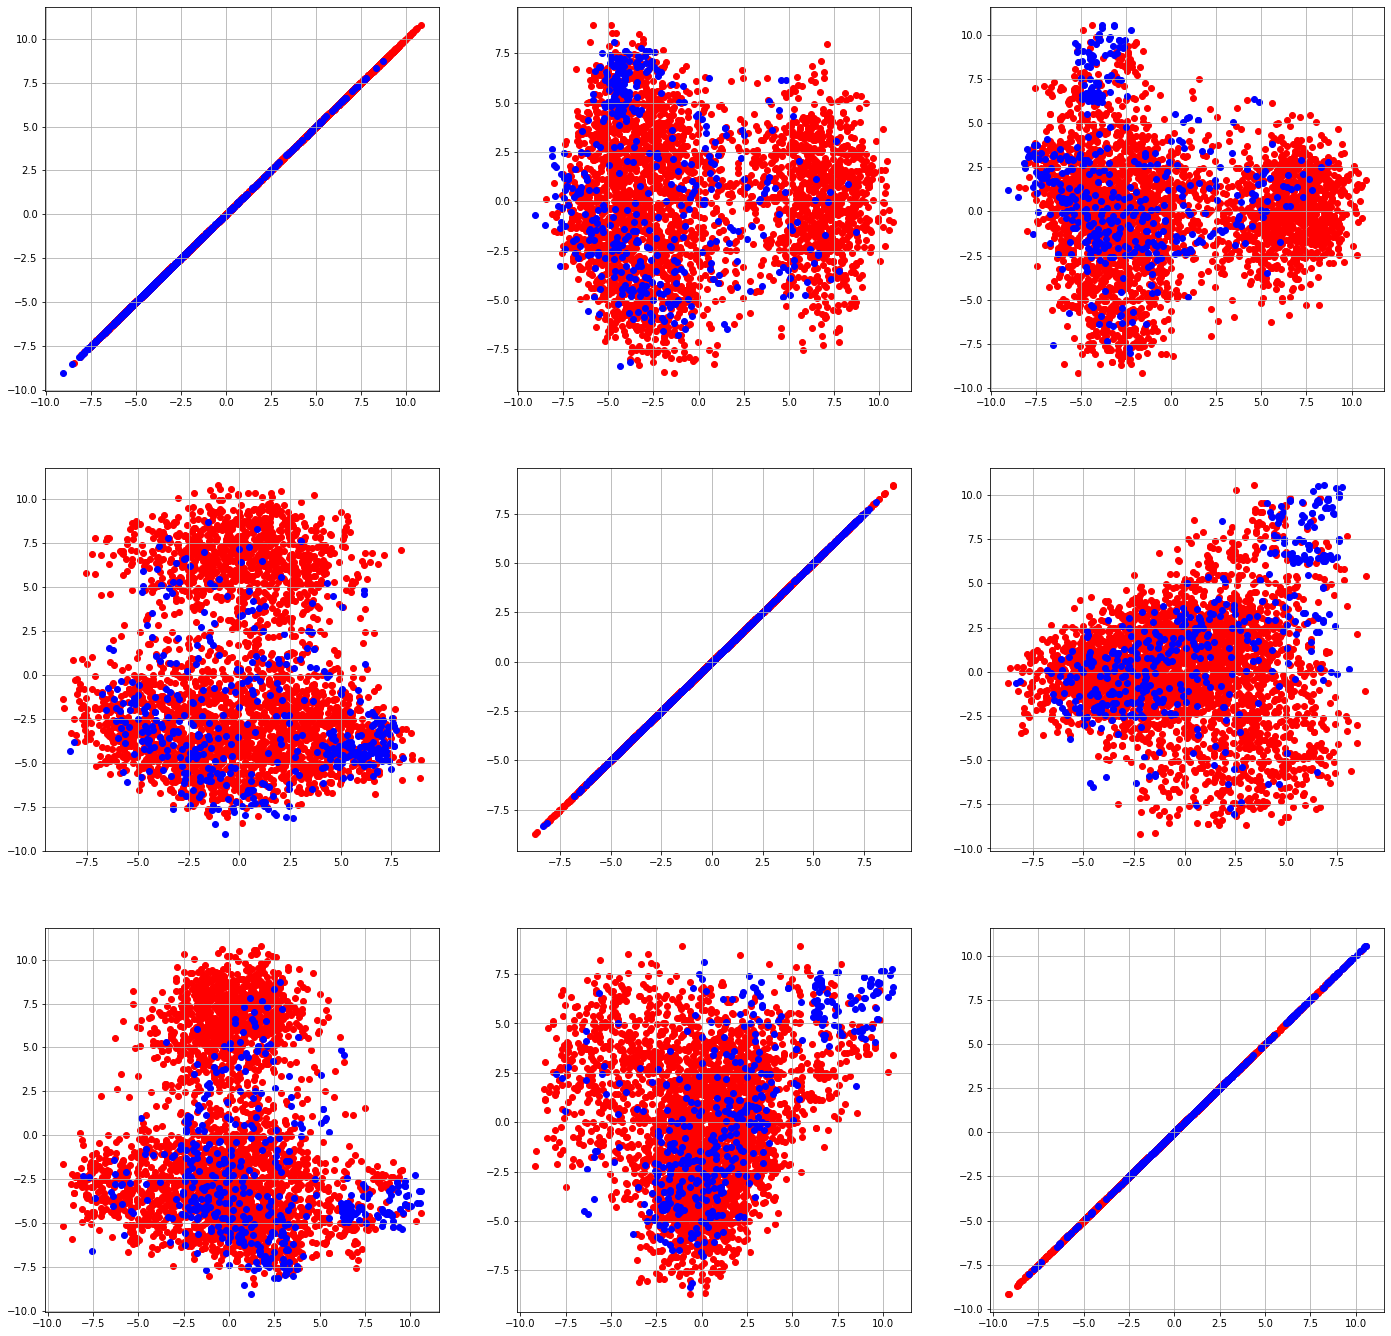

In [ ]:
# Creates a big grid of 2d plots of all pairs of the first 4 principle components. Red points represent the pairs in our original data set and blue points represent the pairs in narrowing senses. 
# We want to find components for which the blue points don't look like they're randomly selected points from the red set
num_comps_grid = 3 # Number of components we want to plot out
fig, axs = plt.subplots(num_comps_grid, num_comps_grid, figsize=(24,24))
for comp1 in range(1, num_comps_grid+1):
  for comp2 in range(1, num_comps_grid+1):
    #axs[comp1-1, comp2-1].set_xlabel('Principal Component ' + str(comp1), fontsize = 4)
    #axs[comp1-1, comp2-1].set_ylabel('Principal Component ' + str(comp2), fontsize = 4)
    #axs[comp1-1, comp2-1].set_title('Components '+str(comp1)+" and "+str(comp2)+ ' PCA', fontsize = 4)
    axs[comp1-1, comp2-1].scatter(principalDf['principal component ' + str(comp1)]
               , principalDf['principal component ' + str(comp2)], c='r')
    axs[comp1-1, comp2-1].scatter(principalDfNarrow['principal component ' + str(comp1)]
              , principalDfNarrow['principal component ' + str(comp2)], c='b')
    axs[comp1-1, comp2-1].grid()
plt.show()

In [ ]:
# Creates a big grid of 2d plots of all pairs of the first 4 principle components. Red points represent the pairs in our original data set and blue points represent the pairs in narrowing senses. 
# We want to find components for which the blue points don't look like they're randomly selected points from the red set
num_comps_grid = 20 # Number of components we want to plot out
fig, axs = plt.subplots(num_comps_grid, num_comps_grid, figsize=(480,480))
for comp1 in range(1, num_comps_grid+1):
  for comp2 in range(1, num_comps_grid+1):
    #axs[comp1-1, comp2-1].set_xlabel('Principal Component ' + str(comp1), fontsize = 4)
    #axs[comp1-1, comp2-1].set_ylabel('Principal Component ' + str(comp2), fontsize = 4)
    #axs[comp1-1, comp2-1].set_title('Components '+str(comp1)+" and "+str(comp2)+ ' PCA', fontsize = 4)
    if comp1 > comp2:
      axs[comp1-1, comp2-1].scatter(mean1PrincipalDf['principal component ' + str(comp1)]
               , mean1PrincipalDf['principal component ' + str(comp2)], c='r')
      axs[comp1-1, comp2-1].scatter(mean2PrincipalDf['principal component ' + str(comp1)]
              , mean2PrincipalDf['principal component ' + str(comp2)], c='b')
    else:
      axs[comp1-1, comp2-1].scatter(mean2PrincipalDf['principal component ' + str(comp1)]
              , mean2PrincipalDf['principal component ' + str(comp2)], c='b')
      axs[comp1-1, comp2-1].scatter(mean1PrincipalDf['principal component ' + str(comp1)]
               , mean1PrincipalDf['principal component ' + str(comp2)], c='r')
    axs[comp1-1, comp2-1].grid()
plt.show()

In [ ]:
# Here we're creating a dataframe where we reverse all of the meanings in datsemshift, to see if any embedding can distinguish original embeddings from reverse embeddings
df_reverse = pd.DataFrame.copy(df)
df_reverse["meaning1"] = df["meaning2"].copy()
df_reverse["meaning2"] = df["meaning1"].copy()
df_bothways = pd.concat([df, df_reverse], axis=0)

In [ ]:
# Creating a big dataframe of each pair of senses the correct way and reversed
mean1_dic_bothways = {i:[vec_dic[df_bothways.iloc[j]["meaning1"]][i] for j in range(len(df_bothways))] for i in range(embed_length)}
mean2_dic_bothways = {embed_length+i:[vec_dic[df_bothways.iloc[j]["meaning2"]][i] for j in range(len(df_bothways))] for i in range(embed_length)}
dic = dict(mean1_dic_bothways)
dic.update(mean2_dic_bothways)
df_embeds_bothways = pd.DataFrame.from_dict(dic)

In [ ]:
# In the next two cells, we find the embeddings of the correctly-ordered meanings and transform the reversed meanings without fitting
pca_bothways = PCA(n_components=num_comps)
df_embeds_correct = df_embeds_bothways[df_embeds_bothways.index < len(df_embeds_bothways)/2]
df_embeds_reverse = df_embeds_bothways[df_embeds_bothways.index >= len(df_embeds_bothways)/2]
principalComponents_bothways = pca_bothways.fit_transform(df_embeds_correct) # Embeddings for the datsemshift pairs. fit_transform tells PCA to fit the embeddings to this data
#print(pca.explained_variance_ratio_)
df_embeds_source = pd.DataFrame(data = principalComponents_bothways
             , columns = ['principal component ' + str(i) for i in range(1, num_comps+1)]) # Converts PCA embeddings to dataframe
principalComponents_bothways = pca_bothways.transform(df_embeds_reverse) # Embeddings for the datsemshift pairs. fit_transform tells PCA to fit the embeddings to this data
#print(pca.explained_variance_ratio_)
df_embeds_target = pd.DataFrame(data = principalComponents_bothways
             , columns = ['principal component ' + str(i) for i in range(1, num_comps+1)]) # Converts PCA embeddings to dataframe

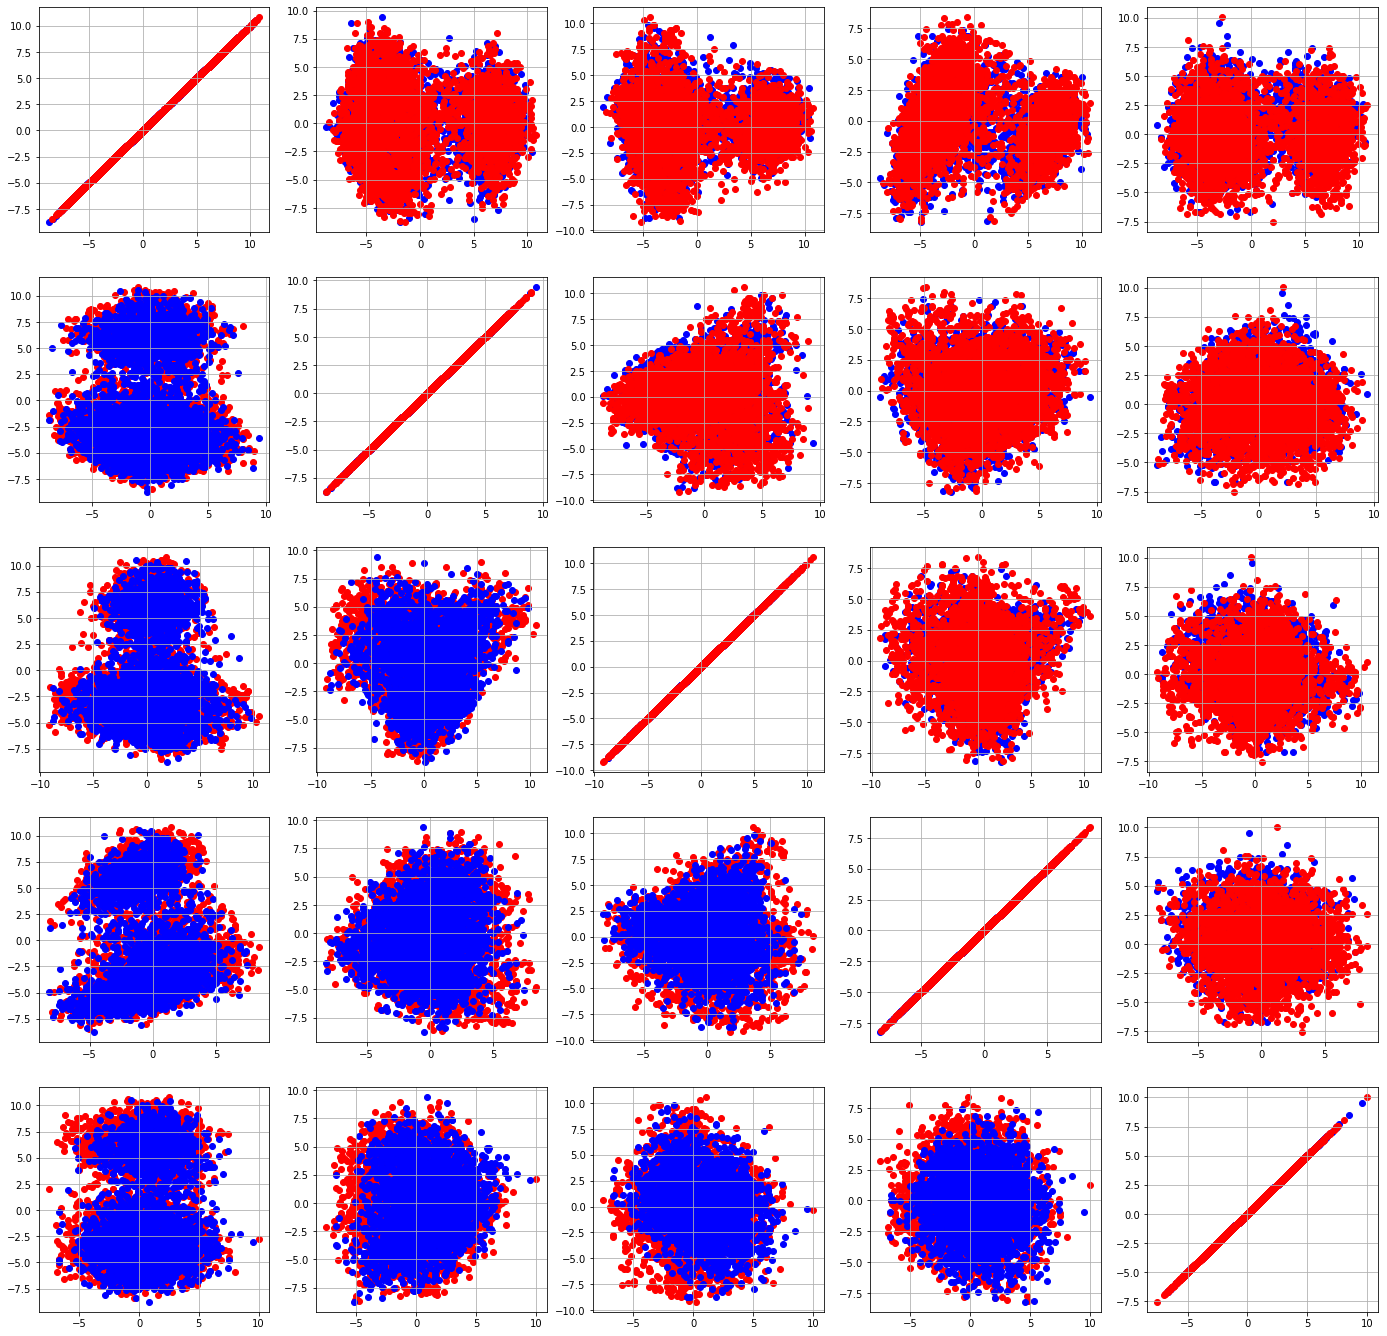

In [ ]:
# Creates a big grid of 2d plots of all pairs of the first 4 principle components. Red points represent the pairs in our original data set and blue points represent the reversed pairs. 
# We want to find components for which the blue points and red points look like different sets
num_comps_grid = 5 # Number of components we want to plot out
fig, axs = plt.subplots(num_comps_grid, num_comps_grid, figsize=(24,24))
for comp1 in range(1, num_comps_grid+1):
  for comp2 in range(1, num_comps_grid+1):
    #axs[comp1-1, comp2-1].set_xlabel('Principal Component ' + str(comp1), fontsize = 4)
    #axs[comp1-1, comp2-1].set_ylabel('Principal Component ' + str(comp2), fontsize = 4)
    #axs[comp1-1, comp2-1].set_title('Components '+str(comp1)+" and "+str(comp2)+ ' PCA', fontsize = 4)
    if comp1 > comp2:
      axs[comp1-1, comp2-1].scatter(df_embeds_source['principal component ' + str(comp1)]
               , df_embeds_source['principal component ' + str(comp2)], c='r')
      axs[comp1-1, comp2-1].scatter(df_embeds_target['principal component ' + str(comp1)]
              , df_embeds_target['principal component ' + str(comp2)], c='b')
    else:
      axs[comp1-1, comp2-1].scatter(df_embeds_target['principal component ' + str(comp1)]
              , df_embeds_target['principal component ' + str(comp2)], c='b')
      axs[comp1-1, comp2-1].scatter(df_embeds_source['principal component ' + str(comp1)]
               , df_embeds_source['principal component ' + str(comp2)], c='r')
    axs[comp1-1, comp2-1].grid()
plt.show()

In [ ]:
# The next few cells do the same as above to the narrowness sets. The caveat here is we don't come up with new dimension-reduced embeddings, we use the same transformation as above

df_label_reverse = pd.DataFrame.copy(df_label)
df_label_reverse["meaning1"] = df_label["meaning2"].copy()
df_label_reverse["meaning2"] = df_label["meaning1"].copy()
df_label_bothways = pd.concat([df_label, df_label_reverse], axis=0)

In [ ]:
df_label_bothways.head()

,meaning1,meaning2
0,brother of man,older brother of man
1,older brother,older brother of man
2,aunt or mother in law,aunt
3,aunt or mother in law,mother in law of woman
4,wolf like animal,dingo


In [ ]:
mean1_dic_label_bothways = {i:[vec_dic[df_label_bothways.iloc[j]["meaning1"]][i] for j in range(len(df_label_bothways))] for i in range(embed_length)}
mean2_dic_label_bothways = {embed_length+i:[vec_dic[df_label_bothways.iloc[j]["meaning2"]][i] for j in range(len(df_label_bothways))] for i in range(embed_length)}
dic = dict(mean1_dic_label_bothways)
dic.update(mean2_dic_label_bothways)
df_embeds_label_bothways = pd.DataFrame.from_dict(dic)

In [ ]:
df_embeds_label_correct = df_embeds_label_bothways[df_embeds_label_bothways.index < len(df_embeds_label_bothways)/2]
df_embeds_label_reverse = df_embeds_label_bothways[df_embeds_label_bothways.index >= len(df_embeds_label_bothways)/2]
principalComponents_label_bothways = pca_bothways.fit_transform(df_embeds_label_correct) # Embeddings for the datsemshift pairs. fit_transform tells PCA to fit the embeddings to this data
#print(pca.explained_variance_ratio_)
df_embeds_label_source = pd.DataFrame(data = principalComponents_label_bothways
             , columns = ['principal component ' + str(i) for i in range(1, num_comps+1)]) # Converts PCA embeddings to dataframe
principalComponents_label_bothways = pca_bothways.transform(df_embeds_label_reverse) # Embeddings for the datsemshift pairs. fit_transform tells PCA to fit the embeddings to this data
#print(pca.explained_variance_ratio_)
df_embeds_label_target = pd.DataFrame(data = principalComponents_label_bothways
             , columns = ['principal component ' + str(i) for i in range(1, num_comps+1)]) # Converts PCA embeddings to dataframe

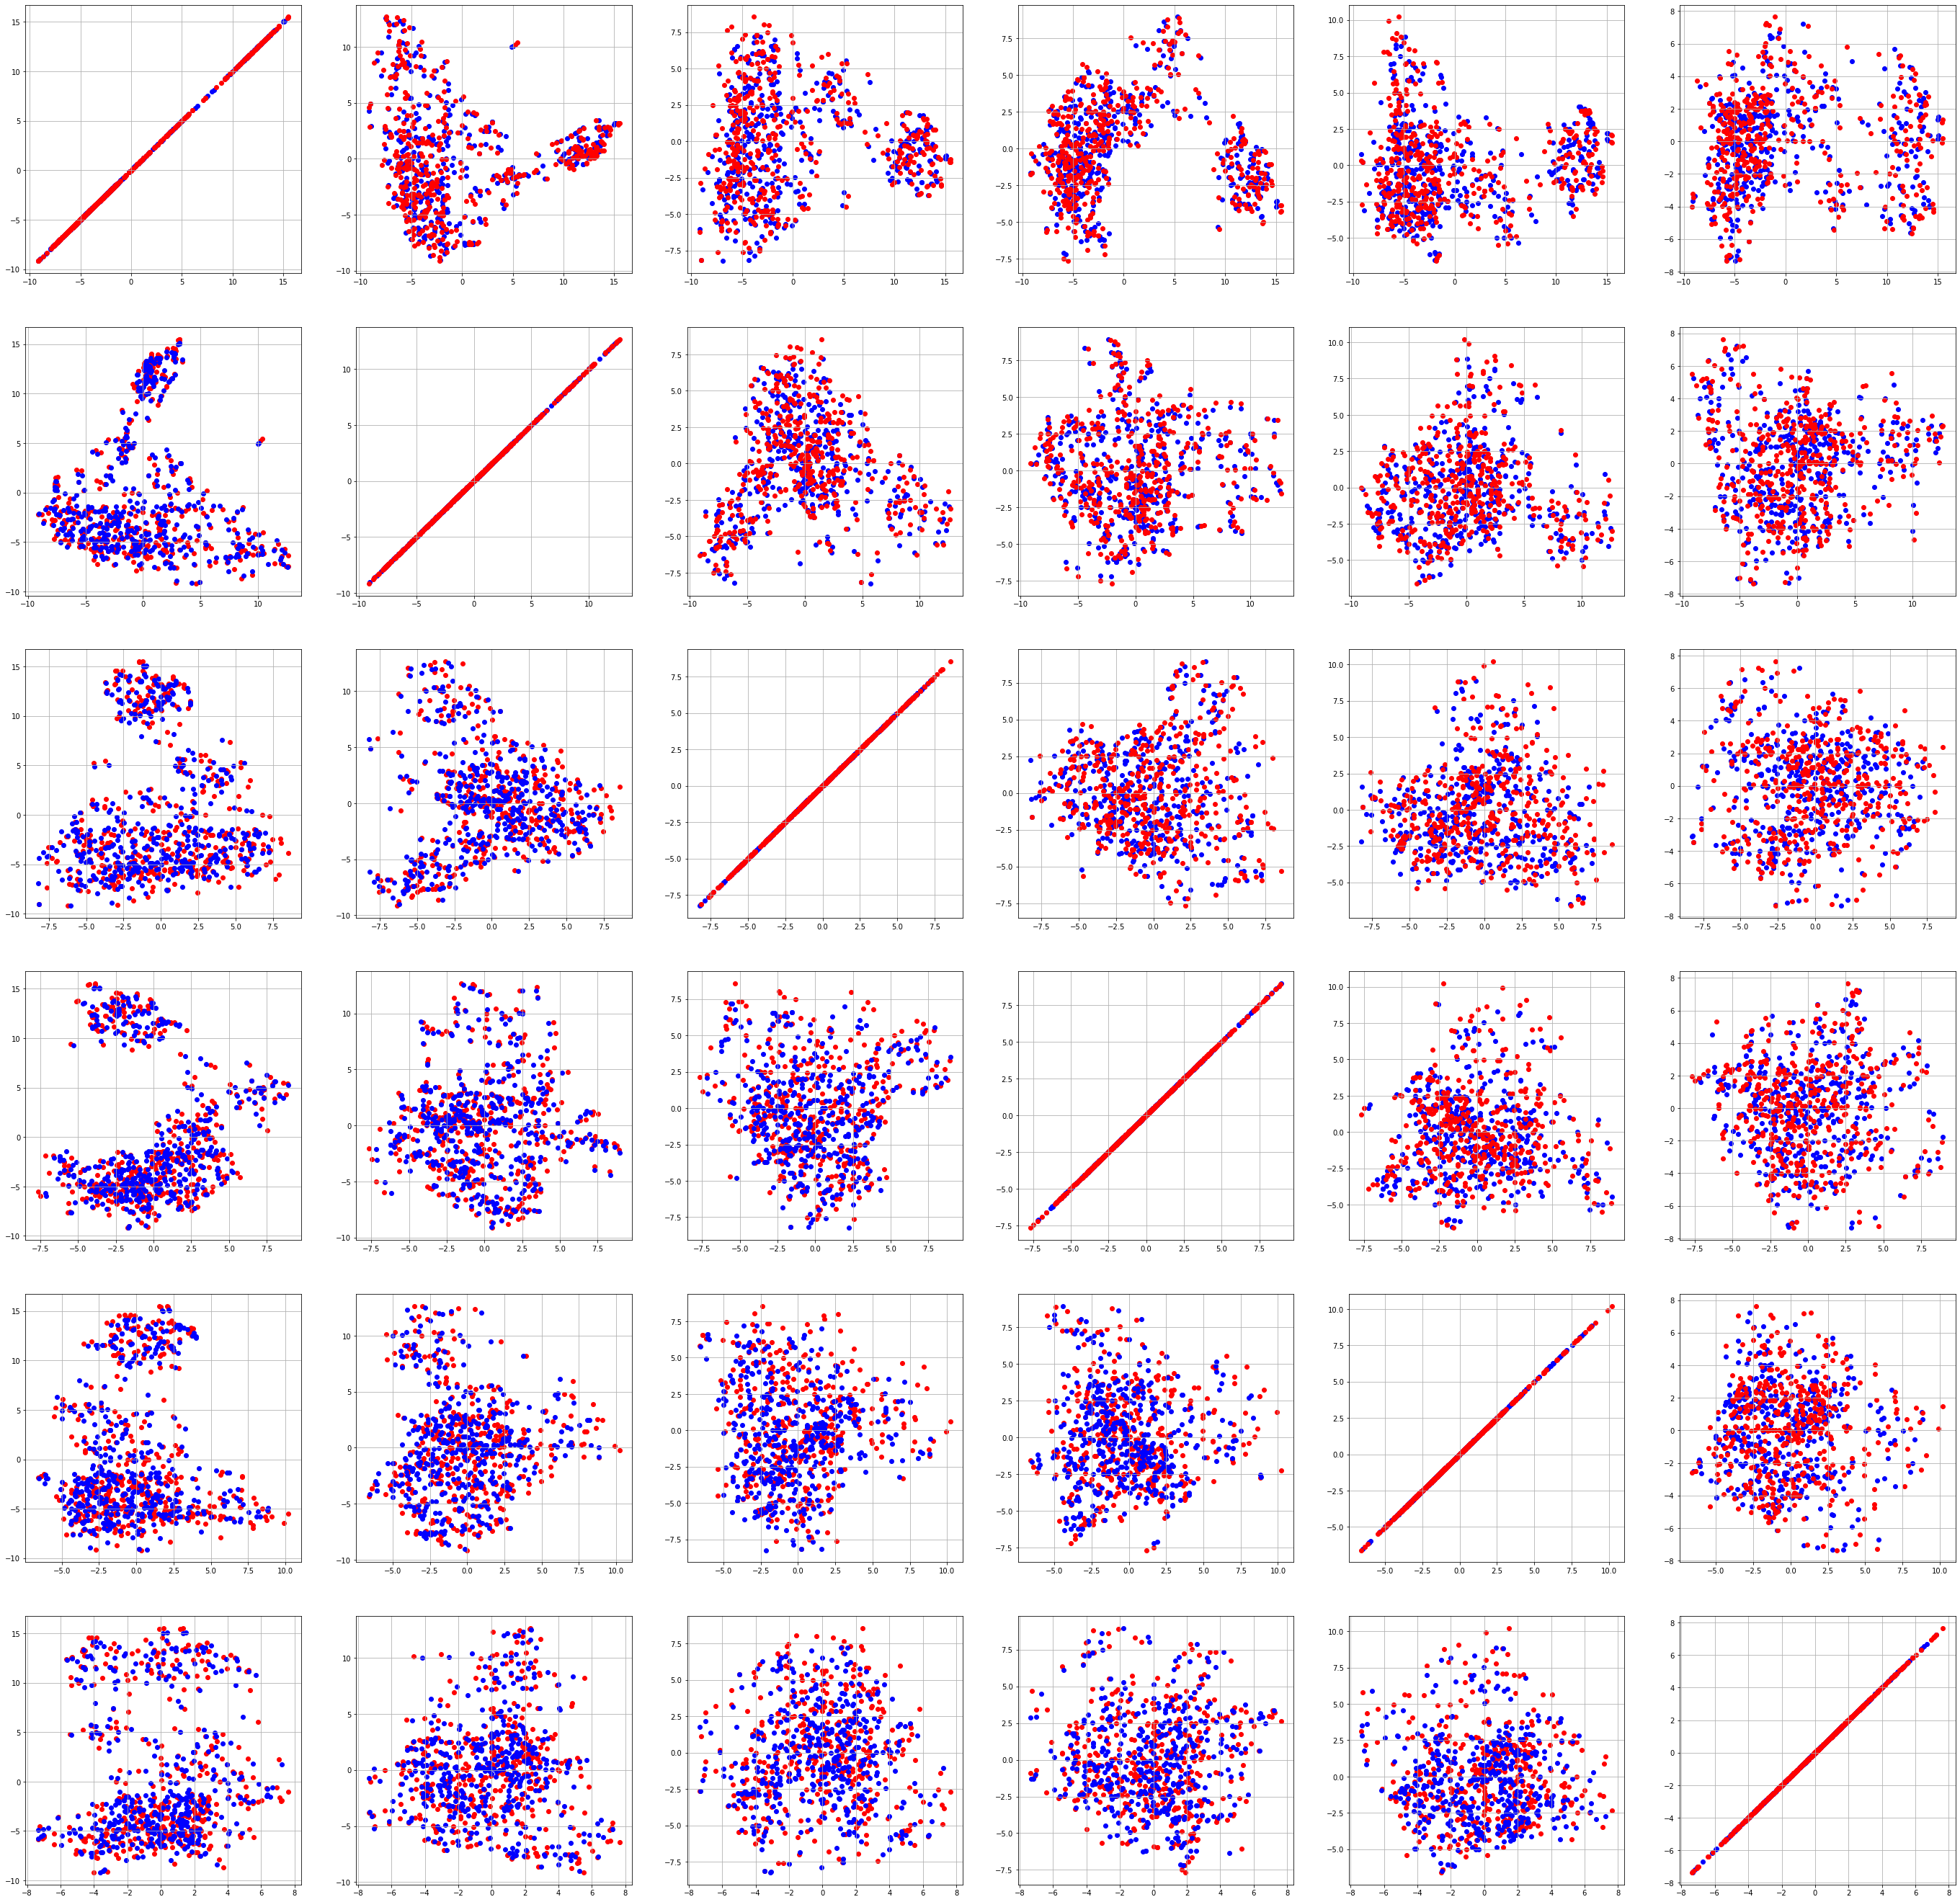

In [ ]:
# Principle components grid where red points are dimension-reduced embeddings of pairs of senses with attested randomness and blue points are those pairs reversed. Useful principal components that detect narrowness would in theory differentiate these sets. 
fig, axs = plt.subplots(num_comps_grid, num_comps_grid, figsize=(48,48))
for comp1 in range(1, num_comps_grid+1):
  for comp2 in range(1, num_comps_grid+1):
    if comp1 > comp2:
      axs[comp1-1, comp2-1].scatter(df_embeds_label_source['principal component ' + str(comp1)]
               , df_embeds_label_source['principal component ' + str(comp2)], c='r')
      axs[comp1-1, comp2-1].scatter(df_embeds_label_target['principal component ' + str(comp1)]
              , df_embeds_label_target['principal component ' + str(comp2)], c='b')
    else:
      axs[comp1-1, comp2-1].scatter(df_embeds_label_target['principal component ' + str(comp1)]
              , df_embeds_label_target['principal component ' + str(comp2)], c='b')
      axs[comp1-1, comp2-1].scatter(df_embeds_label_source['principal component ' + str(comp1)]
               , df_embeds_label_source['principal component ' + str(comp2)], c='r')
    axs[comp1-1, comp2-1].grid()
plt.show()